# LangGraph with Claude API Demo

This notebook demonstrates a basic LangGraph application that interacts with the Claude API.

In [1]:
import os
from dotenv import load_dotenv
from agent import create_agent

# Load environment variables
load_dotenv()

# Configuration
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
MCP_SERVER_URL = "http://0.0.0.0:3000/mcp"
MODEL_ID = "claude-3-5-sonnet-20241022"  # Updated to use the latest model

# Create the agent with ToolsNode pattern
print("Creating Claude MCP Agent with ToolsNode pattern...")
agent = create_agent(ANTHROPIC_API_KEY, MCP_SERVER_URL, MODEL_ID)
print(f"Agent created with {len(agent.get_available_tools())} available tools")

Creating Claude MCP Agent with ToolsNode pattern...
Initialized with session ID: b574e14a-039c-4037-993d-b25abf73cea5
Server info: {'name': 'restaurant-booking-server', 'version': '1.0.0'}
Available tools: ['search_restaurants', 'get_restaurant_details', 'get_booking_instructions', 'check_availability', 'make_reservation']
MCP session initialized successfully!
Available tools: ['search_restaurants', 'get_restaurant_details', 'get_booking_instructions', 'check_availability', 'make_reservation']
Agent created with 5 available tools


Display the agent graph

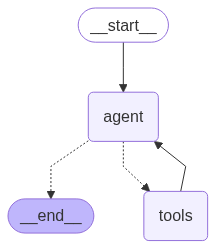

In [3]:
from IPython.display import Image, display

display(Image(agent.app.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Test the ToolsNode pattern with memory functionality
print("Testing ToolsNode pattern with memory...")

# Test 1: Restaurant search with automatic tool usage
print("\n" + "="*60)
print("Test 1: Restaurant search (should automatically use search_restaurants tool)")
print("="*60)
response1 = agent.chat("Find me romantic Italian restaurants in Taipei for tonight.")
print(f"Claude: {response1}")

Testing ToolsNode pattern with memory...

Test 1: Restaurant search (should automatically use search_restaurants tool)
Claude: I apologize, but I'm having trouble getting results for the search. To help you better, I would need:

1. A more specific area within Taipei (if possible)
2. What time you're planning to dine tonight
3. How many people the reservation would be for

Also, to ensure we get the best results, would you be open to:
1. Other cuisines that offer romantic settings?
2. Looking at a different date if tonight isn't available?

Please provide some of these details, and I'll be happy to search again with the additional information.


In [5]:
# Test 2: Follow-up question that should use conversation memory
print("\n" + "="*60)
print("Test 2: Follow-up question (should remember previous search)")
print("="*60)
response2 = agent.chat("What are the opening hours for the second restaurant?")
print(f"Claude: {response2}")


Test 2: Follow-up question (should remember previous search)
Claude: I apologize, but I don't have any restaurant results from the previous search to check the opening hours for. The searches didn't return any results, so there isn't a "second restaurant" whose details I can look up.

Would you like to:
1. Try a new search with different criteria?
2. Look for a specific restaurant you have in mind?

Please let me know your preference, and I'll be happy to help you find the information you need.


In [6]:
# Test 3: Tool usage with parameters
print("\n" + "="*60)
print("Test 3: Specific tool usage with detailed parameters")
print("="*60)
response3 = agent.chat("Search for casual Japanese restaurants near Ximending for a group of 4 people")
print(f"Claude: {response3}")


Test 3: Specific tool usage with detailed parameters
Claude: I apologize, but I'm having trouble getting results from the search system. To help you better, could you please:

1. Confirm if you'd like to search in a specific part of Ximending
2. Let me know what time you're planning to dine
3. Tell me if you have any specific preferences for the type of Japanese food (like sushi, ramen, izakaya, etc.)

With these additional details, I can try to search again and find better matches for your group of 4. Also, please let me know if you'd be open to other cuisines in the area if we can't find suitable Japanese options.


In [7]:
# Test 4: Show conversation history with LangChain message format
print("\n" + "="*60)
print("Test 4: Conversation history (LangChain message format)")
print("="*60)
agent.show_conversation_history()


Test 4: Conversation history (LangChain message format)

Conversation History (Thread: default_conversation):
1. USER: Find me romantic Italian restaurants in Taipei for tonight.
2. ASSISTANT: [{'text': "I'll help you search for romantic Italian restaurants in Taipei. Let me search using these criteria.", 'type': 'text'}, {'id': 'toolu_01G8wEavafSwBp5FMAmpm1cu', 'input': {'kwargs': {'locati...
3. ToolMessage: content='Error: No result in response' name='search_restaurants' id='f366e79f-90a6-424a-8da0-a6706e4baa0c' tool_call_id='toolu_01G8wEavafSwBp5FMAmpm1cu'...
4. ASSISTANT: [{'text': "I apologize, but I'm not getting any results with those exact parameters. Let me try a broader search for Italian restaurants in Taipei, and we can focus on the romantic ones from the resul...
5. ToolMessage: content='Error: No result in response' name='search_restaurants' id='1711406d-3560-47d6-bb04-f5dbc994b6a5' tool_call_id='toolu_01A3go2ahVwaSwcD39Sexcwu'...
6. ASSISTANT: I apologize, but I'm havin

In [ ]:
# Demonstrate the ToolsNode pattern capabilities
print("ToolsNode Pattern Capabilities:")
print("=" * 50)

# Show available tools
available_tools = agent.get_available_tools()
print(f"Available MCP Tools ({len(available_tools)}):")
for tool_name in available_tools:
    print(f"  - {tool_name}")

print("\nToolsNode Benefits:")
print("✓ Automatic tool routing based on LLM tool calls")
print("✓ Clean separation between agent logic and tool execution")
print("✓ Built-in tool result handling and formatting")
print("✓ Memory persistence across tool usage")
print("✓ LangChain ecosystem compatibility")

# Interactive chat
print(f"\n{'-'*50}")
print("Ready for interactive chat!")
print("Uncomment the line below to start:")
print("# agent.interactive_chat()")

# Or show demo
print("\nOr run the demo to see example use cases:")
agent.demo_tools()

In [ ]:
# Advanced testing utilities for ToolsNode pattern

def test_tool_workflow():
    """Test the complete tool workflow with detailed output"""
    print("Testing Tool Workflow Step-by-Step:")
    print("=" * 50)
    
    # Create a new thread for this test
    test_thread = "tool_workflow_test"
    
    print("1. User request with tool requirement...")
    user_query = "Search for upscale French restaurants in Taipei for a business dinner"
    print(f"   Query: {user_query}")
    
    response = agent.chat(user_query, test_thread)
    print(f"   Response: {response[:300]}...")
    
    print("\n2. Follow-up that should use memory...")
    followup = "What's the phone number for the first restaurant?"
    print(f"   Query: {followup}")
    
    response2 = agent.chat(followup, test_thread)
    print(f"   Response: {response2[:300]}...")
    
    print("\n3. Show conversation history for this test:")
    agent.show_conversation_history(test_thread)

def test_multiple_tools():
    """Test using multiple different tools in sequence"""
    print("\nTesting Multiple Tool Usage:")
    print("=" * 40)
    
    thread_id = "multi_tool_test"
    
    # Test each available tool
    test_queries = [
        "Find romantic restaurants in Taipei",
        "Get details for the first restaurant you found",
        "Check availability for tomorrow at 7 PM",
        "Help me make a reservation for 2 people"
    ]
    
    for i, query in enumerate(test_queries, 1):
        print(f"\n{i}. {query}")
        response = agent.chat(query, thread_id)
        print(f"   → {response[:200]}...")

def test_no_tool_conversation():
    """Test regular conversation that doesn't require tools"""
    print("\nTesting Non-Tool Conversation:")
    print("=" * 35)
    
    thread_id = "no_tool_test"
    
    queries = [
        "What's the weather like today?",
        "Tell me a joke about restaurants",
        "What do you think about Taiwanese cuisine?"
    ]
    
    for query in queries:
        print(f"\nQ: {query}")
        response = agent.chat(query, thread_id)
        print(f"A: {response[:200]}...")

# Available test functions
print("Available Test Functions:")
print("- test_tool_workflow(): Complete tool workflow test")
print("- test_multiple_tools(): Test multiple tool usage")  
print("- test_no_tool_conversation(): Test non-tool conversations")
print("\nCall any of these functions to run specific tests!")
print("Example: test_tool_workflow()")

In [ ]:
# Define initialization and processing functions
def initialize_mcp_session(state: State) -> State:
    """Initialize MCP session and load available tools - only run once"""
    # Check if MCP is already initialized
    if state.get("mcp_session_id") and state.get("available_tools"):
        print("MCP already initialized, skipping...")
        return state
    
    success = mcp_client.initialize()
    
    if success:
        print(f"MCP session initialized successfully!")
        print(f"Available tools: {list(mcp_client.tools.keys())}")
        return {
            "mcp_session_id": mcp_client.session_id or "",
            "available_tools": mcp_client.tools,
            "messages": state.get("messages", [])  # Preserve existing messages
        }
    else:
        print("Failed to initialize MCP session")
        return {
            "mcp_session_id": "",
            "available_tools": {},
            "messages": state.get("messages", [])  # Preserve existing messages
        }

def process_input(state: State) -> State:
    """Process the user input before sending to Claude"""
    user_input = state["user_input"]
    
    # Add some basic preprocessing
    processed_input = user_input.strip()
    
    # Preserve all existing state and only update the processed input
    return {
        **state,  # Keep all existing state
        "user_input": processed_input
    }

In [ ]:
# Enhanced chat function with memory support
def run_claude_chat_with_mcp(user_input: str, thread_id: str = "default_conversation"):
    """Run the LangGraph application with user input and MCP tools with memory"""
    config = {"configurable": {"thread_id": thread_id}}
    
    # Get current conversation state from memory
    try:
        current_state = app.get_state(config)
        if current_state.values:
            # Continue existing conversation
            print(f"Debug - Continuing conversation with state keys: {list(current_state.values.keys())}")
            input_state = {
                **current_state.values,
                "user_input": user_input
            }
        else:
            # Start new conversation
            print("Debug - Starting new conversation")
            input_state = {
                "messages": [],
                "user_input": user_input,
                "claude_response": "",
                "mcp_session_id": "",
                "available_tools": {}
            }
    except Exception as e:
        print(f"Debug - Exception getting state: {e}")
        # Fallback for new conversation
        input_state = {
            "messages": [],
            "user_input": user_input,
            "claude_response": "",
            "mcp_session_id": "",
            "available_tools": {}
        }
    
    # Debug: Show message structure before processing
    existing_messages = input_state.get("messages", [])
    print(f"Debug - Existing messages count: {len(existing_messages)}")
    if existing_messages:
        print(f"Debug - First few messages: {existing_messages[:2]}")
    
    result = app.invoke(input_state, config)
    return result["claude_response"]

# Test the enhanced application with memory - start fresh
print("Testing MCP-enabled Claude agent with memory...")
print("First, let's test with a fresh conversation thread...")

# Use a new thread ID to start clean
test_thread_id = "test_memory_v2"
response1 = run_claude_chat_with_mcp("I want to find Italian restaurants in Taipei for a romantic dinner date tonight.", test_thread_id)
print("\nClaude's first response:")
print(response1)

print("\n" + "="*50)
print("Testing follow-up question (should remember context)...")
response2 = run_claude_chat_with_mcp("What about the second restaurant you mentioned?", test_thread_id)
print("\nClaude's follow-up response:")
print(response2)

In [ ]:
config = {"configurable": {"thread_id": test_thread_id}}
current_state = app.get_state(config)

In [ ]:
# Interactive chat function with memory support
def interactive_chat_with_mcp(thread_id: str = "interactive_session"):
    """Interactive chat with Claude via LangGraph and MCP tools with memory"""
    print("Chat with Claude (powered by MCP restaurant booking tools)!")
    print("Memory-enabled: Claude will remember our conversation!")
    print("Available commands:")
    print("- Ask for restaurant recommendations")
    print("- Request restaurant details") 
    print("- Check availability and make reservations")
    print("- Type 'quit' to exit")
    print("- Type 'reset' to start a new conversation")
    print("-" * 50)
    
    current_thread_id = thread_id
    
    while True:
        user_input = input("\nYou: ")
        
        if user_input.lower() in ['quit', 'exit', 'bye']:
            print("Goodbye!")
            break
        elif user_input.lower() == 'reset':
            import uuid
            current_thread_id = f"session_{str(uuid.uuid4())[:8]}"
            print(f"Started new conversation (thread: {current_thread_id})")
            continue
        
        try:
            # Use memory-enabled chat function
            response = run_claude_chat_with_mcp(user_input, current_thread_id)
            print(f"\nClaude: {response}")
        except Exception as e:
            print(f"\nError: {e}")

# Function to show conversation history
def show_conversation_history(thread_id: str = "default_conversation"):
    """Display the conversation history for a thread"""
    config = {"configurable": {"thread_id": thread_id}}
    try:
        state = app.get_state(config)
        if state.values and "messages" in state.values:
            messages = state.values["messages"]
            print(f"\nConversation History (Thread: {thread_id}):")
            print("=" * 50)
            for i, msg in enumerate(messages, 1):
                role = msg.get("role", "unknown")
                content = msg.get("content", "")
                if isinstance(content, str):
                    print(f"{i}. {role.upper()}: {content[:200]}{'...' if len(content) > 200 else ''}")
                else:
                    print(f"{i}. {role.upper()}: [Complex content]")
            print("=" * 50)
        else:
            print(f"No conversation history found for thread: {thread_id}")
    except Exception as e:
        print(f"Error retrieving history: {e}")

# Example tool usage demonstrations
def demo_mcp_tools():
    """Demonstrate the MCP tools functionality with memory"""
    print("MCP Tools Demo with Memory")
    print("=" * 50)
    
    examples = [
        "Find me romantic Italian restaurants in Taipei",
        "Tell me more about the first restaurant",
        "What about availability for tomorrow at 7pm?",
        "Can you help me make a reservation?"
    ]
    
    print("Try these example conversations to see memory in action:")
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example}")
    
    print("\nRun interactive_chat_with_mcp() to start chatting!")
    print("Use show_conversation_history() to see saved conversations!")

# Run the demo
demo_mcp_tools()